# TP4: Analyse de données (suite): clustering
## Objectif
Dans ce TP l'objectif est d'implémenter un type d'analyse de données de façon non supervisée en faisant du "clustering", c'est à dire en cherchant des groupes de données qui se ressemblent, sans information préalable sur leurs catégories  
Par exemple si on observe ces points en deux dimensions, on peut distinguer trois groupes relativement séparés

<img src="TP/cluster_init3.png">

Un algorithme de clustering est un algorithme qui est censé repérer ces groupes, éventuellement en supposant le nombre de groupes à chercher. 

## Bibliothèques logicielles utilisées
Pour garantir le bon fonctionnement du code, lancez prélablement l'installation des bibliothèques logicielles suivantes :

In [3]:
! pip install numpy 
! pip install matplotlib
! pip install ipython
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.5 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 18.1 MB/s eta 0:00:00


## Première partie: la méthodes des k moyennes

Vous allez implémenter la méthodes des k moyennes sur des données artificielles, en utilisant la fonction qui génère des nuages de point du TP3  
Cet algorithme suit le principe suivant, en présupposant qu'on fixe le nombre de groupes $k$
- tirer au hasard k points dans l'espace voulu: ce seront les centres des clusters
- répéter jusqu'à convergence 
    - assigner chaque point au cluster dont le centre est le plus proche
    - recalculer les centres des clusters: le nouveau centre est le barycentre des points du cluster (moyenne)
        
Un critère de convergence classique est de voir que la différence des distances des centres des clusters devient négligeable. On peut aussi fixer un nombre maximal d'itérations, mais ce n'est pas du tout optimal.  
Indice: Vous pouvez utiliser numpy pour simplifier les calculs.

Voici ce que donnerait un exemple d'éxécution sur les données ci-dessus, en choississant 2, 3 ou 4 clusters. Ici les couleurs sont assignées à chaque cluster repéré, pour faciliter la visualisation.  

<table>
    <tr>
    <td> <img src="TP/kmeans_3_2.png" width="400"></td>
    <td> <img src="TP/kmeans_3_3.png" width="400"></td>
      <td>   <img src="TP/kmeans_3_4.png" width="400"></td>
    </tr>
</table>

La croix indique le centre calculé pour chaque cluster. 

<strong> Attention </strong>: on génère des blobs pour avoir un exemple, mais évidemment l'algorithme de k-means n'a aucune information sur l'origine des données: il ne voit que l'ensemble total de tous les points. Vous pouvez générer n'importe quel nombre n de blobs, et tester les k-means avec k=ce que vous voulez (2, 3, 15, ...).  
Voici une correction possible pour la fonction blob du TP3, qui renvoie une matrice numpy:

In [4]:
import numpy as np

def blob(x0,y0,n,scale=1.):
    """
    nuage de points autour de (x,y)
    """   
    return np.random.uniform(low=np.array((x0,y0))-scale,high=np.array((x0,y0))+scale,size=(n,2))

g1 = blob(0.5,0.8,20,scale=0.1)
print(g1.shape)
print(g1[:5,])

(20, 2)
[[0.59965268 0.88546107]
 [0.4995817  0.77495253]
 [0.52787097 0.8835348 ]
 [0.52710537 0.77724782]
 [0.499137   0.82702655]]


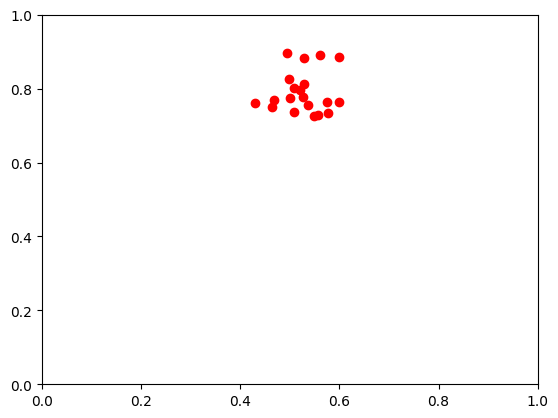

In [5]:
import matplotlib.pyplot as plt
plt.xlim((0,1))
plt.ylim(0,1)
plt.plot(g1[:,0],g1[:,1],"ro")

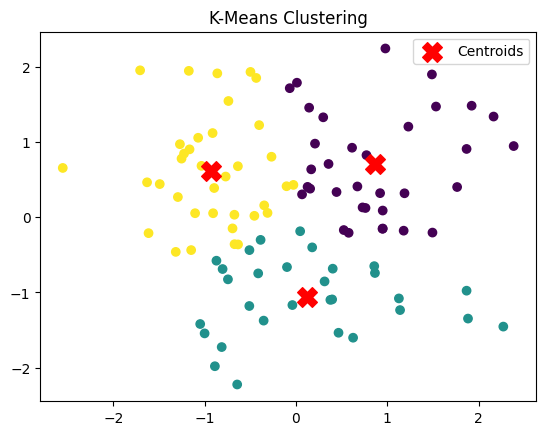

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Générer des données aléatoires pour l'exemple
np.random.seed(0)
X = np.random.randn(100, 2)  # 100 points en 2D

# Nombre de clusters à rechercher (vous pouvez le modifier)
k = 3

# Initialiser les centres de cluster de manière aléatoire
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

# Fonction pour attribuer chaque point au cluster le plus proche
def assign_to_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Fonction pour recalculer les centres des clusters
def update_centroids(X, labels, k):
    new_centroids = np.zeros((k, X.shape[1]))
    for cluster in range(k):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 0:
            new_centroids[cluster] = np.mean(cluster_points, axis=0)
        else:
            # Si un cluster est vide, conservez le centre existant
            new_centroids[cluster] = centroids[cluster]
    return new_centroids

# Fonction pour vérifier la convergence
def has_converged(centroids, new_centroids, tol=1e-4):
    return np.all(np.abs(centroids - new_centroids) < tol)

# Algorithme des k-moyennes
max_iterations = 100
for i in range(max_iterations):
    # Étape 1 : Attribution des points aux clusters
    labels = assign_to_clusters(X, centroids)

    # Étape 2 : Recalcul des centres des clusters
    new_centroids = update_centroids(X, labels, k)

    # Vérification de la convergence
    if has_converged(centroids, new_centroids):
        break

    centroids = new_centroids

# Tracé des points colorés par cluster
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.legend()
plt.title('K-Means Clustering')
plt.show()


## Deuxième partie: de "vraies" données

Nous allons maintenant utiliser le fichier "iris.txt", du TP3 qui contient les caractéristiques de différentes fleurs d'espèce iris, réparties en trois sous-espèces : "setosa", "virginica", "versicolor".  
Pour lire directement les données nous utiliserons la bibliothèque logicielle `numpy` avec la méthode `genfromtxt()`

In [7]:
import numpy as np
data = np.genfromtxt('iris.txt', dtype=None,delimiter=',',names=True,encoding="utf8")

En supposant qu'on ne connait pas la classe de chaque point, lancez `kmeans` pour voir quels groupes seraient fait automatiquement.  
Par exemple en cherchant 3 classes sur les données avec seulement les traits "sepal length", "petal width":    

<img src="TP/iris_pw_sl_3.png" width="600">

Vous pouvez comparer aux vraies classes !

<img src="TP/iris_pw_sl_real.png" width="600">

Pour cela (quand on connait les vraies catégories bien sûr) on peut calculer la "pureté" des clusters c'est à dire la proportion de la classe la plus représentée dans chaque cluster, et faire la moyenne sur l'ensemble des classes.  
Ecrivez une fonction qui implémente cette mesure sur un ensemble de données: pour chaque point on connait la "vraie" classe, et on a le résultat du clustering.  
Note : On reverra ceci et d'autres méthodes de clustering au 2e semestre dans le cours d'apprentissage. 

### Le programme
**Note importante pour bien comprendre le fonctionnement de la fonction `compute_purity`**

**`np.unique(cluster_labels)`**  
Renvoie un tableau contenant les valeurs uniques des étiquettes de cluster. En d'autre termes cela signifie que nous obtenons une liste des clusters uniques présents dans `cluster_labels`.

**`[labels[cluster_labels == cluster] for cluster in np.unique(cluster_labels)]`**  
Crée une liste de tableaux où chaque tableau contient les étiquettes réelles associées à chaque cluster unique. Pour chaque cluster unique, nous obtenons un tableau d'étiquettes correspondantes.

**`return_counts=True`**  
Indique à np.unique de retourner également les comptages d'occurrences des étiquettes. Ainsi, nous obtenons un tableau de deux éléments pour chaque cluster unique : 
* une liste d'étiquettes uniques
* une liste de comptages correspondants

**`np.max(...)`**  
Pour chaque cluster, nous prenons la valeur maximale dans la liste de comptages d'occurrences. Appellée, **classe majoritaire** du cluster elle nous donne le nombre d'occurrences de la classe la plus fréquente dans le cluster. 

**`np.sum(cluster_labels == cluster)`**  
Calcule le nombre total d'éléments dans le cluster en utilisant la comparaison `cluster_labels == cluster`, qui renvoie un tableau booléen indiquant si chaque élément de cluster_labels appartient au cluster actuellement en cours d'examen. En sommant ce tableau booléen, nous obtenons le nombre total d'éléments dans le cluster.

Enfin, en divisant le nombre d'occurrences de la classe majoritaire par le nombre total d'éléments dans le cluster nous obtenons la pureté du cluster.

Pour résumer, `cluster_purities` est une liste de puretés pour chaque cluster, où la pureté mesure à quel point la classe majoritaire prédomine dans ce cluster. Une pureté élevée indique que la majorité des éléments dans le cluster appartiennent à la même classe, ce qui est plus que souhaitable pour un bon clustering.

Pureté des clusters: 0.91


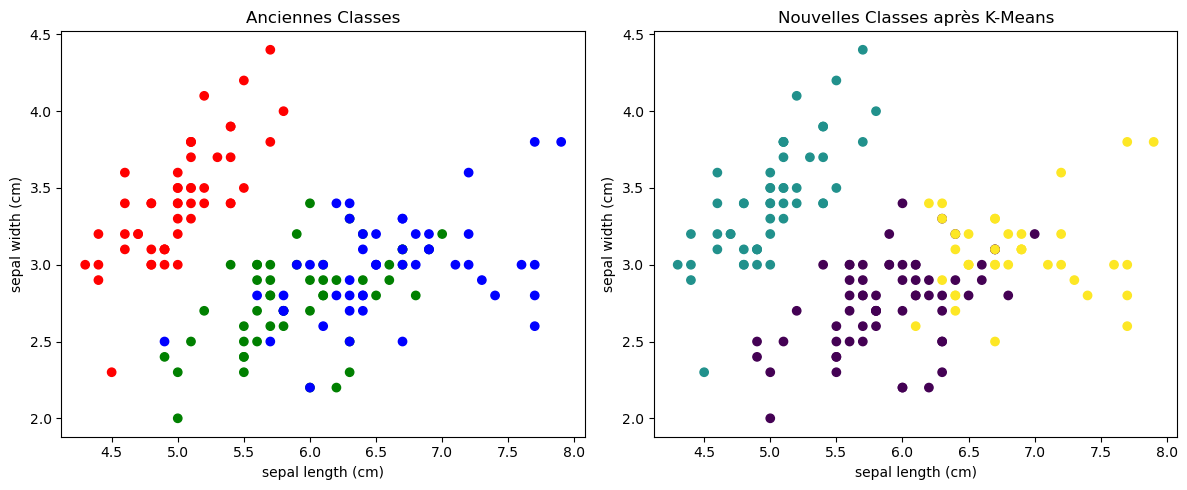

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les données iris depuis le fichier
data = np.genfromtxt('iris.txt', delimiter=',', skip_header=1, usecols=(0, 1, 2, 3), dtype=float)
labels = np.genfromtxt('iris.txt', delimiter=',', skip_header=1, usecols=4, dtype=str)

num_clusters = 3                                                        # Défini le nombre de clusters (groupes)

kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)     # Crée l'objet KMeans avec 3 clusters et une initialisation de 10 essais
cluster_labels = kmeans.fit_predict(data)                               # Applique K-Means (l'algorithme des k-moyennes) aux données

# Fonction pour calculer la pureté des clusters
def compute_purity(labels, cluster_labels):
    cluster_purities = [np.max(np.unique(labels[cluster_labels == cluster], return_counts=True)[1]) / np.sum(cluster_labels == cluster) for cluster in np.unique(cluster_labels)]
    return np.mean(cluster_purities)

purity = compute_purity(labels, cluster_labels)  # Calcule la pureté des clusters
print(f'Pureté des clusters: {purity:.2f}')      # Affiche la pureté des clusters

# Affichage des graphiques
plt.figure(figsize=(12, 5))

# Anciennes classes
plt.subplot(1, 2, 1)
colors = {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}
true_colors = np.array([colors[label] for label in labels])
plt.scatter(data[:, 0], data[:, 1], c=true_colors)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Anciennes Classes')

# Nouvelles classes après K-Means
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Nouvelles Classes après K-Means')

plt.tight_layout()
plt.show()


**Conclusion**  
Là ou une pureté de 1.0 signifierait une correspondance parfaite avec les vraies classes, ici nous obtenons un résultat de 0.91, soit un score très encourageant.  
Ainsi l'algorithme K-Means a bien réussi à regrouper les données en fonction de leurs caractéristiques de manière cohérente avec les classes d'iris réelles.